<h1 style="color:#ff5500; font-family:Play; font-size:3em; margin:auto 32px;align:center">Part V - Model Selection</h1>

---

This document is a part of the FACEIT Predictor Data Science Workflow.

In this notebook the Machine Learning Model is selected and its hyperparameters are tuned. Feature selection is also considered.

# Imports


In [120]:
# Measure code execution time
from time import time

# Manage warnings
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# regex
import re

from datetime import datetime

# Model Storage
import joblib

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import StandardScaler

# Model selection and hyperparameter tuning
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV

# Feature selection
from sklearn.feature_selection import RFECV

# Classifiers
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from xgboost import XGBClassifier

# Stacking Classifier
from sklearn.ensemble import StackingClassifier

# Neural network libraries
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Classifier metrics
from sklearn.metrics import RocCurveDisplay, classification_report, roc_auc_score

# enable imports from parent directory
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# import local modules
from src.utils.loaders import read_data
from src.utils.dirs import MODEL_DIR
from src.utils.visualization import set_visualization_defaults, comp_featured_based_on_winner

from IPython import get_ipython

ipython = get_ipython()

# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
   %load_ext autoreload

# autoreload python modules
%autoreload 2

In [2]:
set_visualization_defaults()

In [3]:
SEED = 15

# Load Processed Data

In [4]:
data = read_data("processed")

In [5]:
X = data.drop(columns=["winner", "_id"])
y = data["winner"]

Scaling data is crucial for performance of some algorithms.

**TODO: there are several scalers available. Which one should be used?**

In [6]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

Split 70% of the data into the train dataset and the remaining 30% into the test dataset.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [8]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (48241, 47)
X_test shape: (20676, 47)


# Baseline Model

In [9]:
rf = RandomForestClassifier(random_state=SEED)

In [10]:
rf.fit(X_train, y_train);

## Evaluation Fundamentals

Too evaluate a classification model the five most common metrics are:

* Accuracy
* Precision
* Recall
* F1-Score
* AUC (Area under the ROC curve)

**TODO: talk about the most important measures and how they will be presented**

In [11]:
def print_metrics(model, X_train, y_train, X_test, y_test):
    pred = model.predict(X_test)

    report = classification_report(y_test, pred, output_dict=True)

    test_acc = report.pop("accuracy")
    train_acc = model.score(X_train, y_train)

    report_df = pd.DataFrame(report)
    
    display(report_df.style.set_caption('Classification Report'))
    
    print(f"Train Accuracy: {train_acc:.4f}\t\tTest Accuracy: {test_acc:.4f}")
    roc_graph = RocCurveDisplay.from_estimator(rf, X_test, y_test)
    roc_graph.ax_.set_title(f'AUC: {roc_graph.roc_auc}')
    roc_graph.ax_.get_legend().remove()
    roc_graph.figure_.set_size_inches(8, 6)

,0,1,macro avg,weighted avg
precision,0.602503,0.607463,0.604983,0.604969
recall,0.629736,0.579685,0.604711,0.604856
f1-score,0.615819,0.593249,0.604534,0.604599
support,10398.000000,10278.000000,20676.000000,20676.000000


Train Accuracy: 1.0000		Test Accuracy: 0.6049


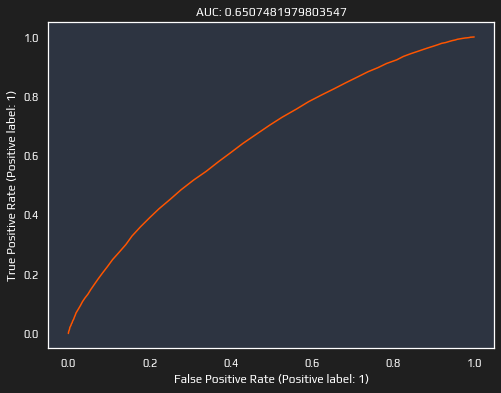

In [12]:
print_metrics(rf, X_train, y_train, X_test, y_test)

In [13]:
feature_importances_df = pd.DataFrame({"features":X_train.columns, "importances":rf.feature_importances_})
feature_importances_df.sort_values(by="importances", ascending=False).head(20)

,features,importances
3,dif_mean_elo,0.045815
29,dif_mean_weighted_kd_by_elo_prev,0.037468
31,dif_mean_rating_prev,0.028639
15,dif_mean_kd_on_map,0.028203
13,dif_mean_matches_on_map,0.028156
18,dif_mean_matches_map_preference,0.027384
28,dif_mean_kd_prev,0.027312
4,dif_stddev_elo,0.027251
9,dif_mean_winrate,0.026969
38,dif_mean_dif_elo_prev,0.026955


# Traditional Classifiers (Sklearn)

In [85]:
clfs = {}
clfs.update({"Linear Disc. Analysis": LinearDiscriminantAnalysis()})
clfs.update({"AdaBoost": AdaBoostClassifier(random_state=SEED)})
clfs.update({"Bagging": BaggingClassifier(random_state=SEED)})
clfs.update({"Extra Trees Ensemble": ExtraTreesClassifier(random_state=SEED)})
clfs.update({"Gradient Boosting": GradientBoostingClassifier(random_state=SEED)})
clfs.update({"Random Forest": RandomForestClassifier(random_state=SEED)})
clfs.update({"Ridge": RidgeClassifier(random_state=SEED)})
clfs.update({"Logistic Regression": LogisticRegression(random_state=SEED)})
clfs.update({"BernoulliNB": BernoulliNB()})
clfs.update({"Multi Layer Perceptron": MLPClassifier(random_state=SEED)})
clfs.update({"Linear SVC": LinearSVC(random_state=SEED)})
clfs.update({"Decision Tree": DecisionTreeClassifier(random_state=SEED)})
clfs.update({"Extra Tree": ExtraTreeClassifier(random_state=SEED)})
clfs.update({"XGB": XGBClassifier(random_state=SEED)})


# Create dict for classifiers with feature_importances_ attribute
has_feature_importances = {
    "AdaBoost",
    "Extra Trees Ensemble",
    "Gradient Boosting",
    "Random Forest",
    "Decision Tree",
    "Extra Tree",
    "XGB",
}

In [20]:
warnings.filterwarnings("ignore")

scoring_metrics = ('accuracy', 'roc_auc')
cv_folds = 5

In [17]:
clfs_df, fts_imp_df = [], []

for name, clf in clfs.items():
    print("Fitting", name)

    index = pd.MultiIndex.from_product([[name], range(cv_folds)], names=["classifier", "fold_number"])
    output = cross_validate(clf, X_train, y_train, cv=cv_folds, scoring=scoring_metrics, return_train_score=True, return_estimator=True)

    clfs_df.append(pd.DataFrame(output, index=index))

    if name in has_feature_importances:
        fts_imp_df.append(pd.DataFrame([e.feature_importances_ for e in output["estimator"]], index=index, columns=X_train.columns))


clfs_df = pd.concat(clfs_df)
fts_imp_df = pd.concat(fts_imp_df)

Fitting Linear Disc. Analysis
Fitting AdaBoost
Fitting Bagging
Fitting Extra Trees Ensemble
Fitting Gradient Boosting
Fitting Random Forest
Fitting Ridge
Fitting Logistic Regression
Fitting BernoulliNB
Fitting Multi Layer Perceptron
Fitting Linear SVC
Fitting Decision Tree
Fitting Extra Tree
Fitting XGB


In [18]:
ordered_clfs_df = clfs_df.groupby(by="classifier").median().sort_values(by="test_accuracy", ascending=False)
ordered_clfs_df

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
classifier,,,,,,
Linear SVC,12.946416,0.011935,0.616915,0.616848,0.666948,0.667455
Ridge,0.082778,0.010974,0.615775,0.616718,0.666692,0.667275
Linear Disc. Analysis,0.338065,0.009722,0.615568,0.616744,0.666696,0.667275
Logistic Regression,0.773940,0.009976,0.615568,0.617677,0.667274,0.667575
Gradient Boosting,45.823507,0.046902,0.610075,0.633586,0.661058,0.690388
AdaBoost,8.677763,0.230384,0.608624,0.617755,0.656199,0.668735
Extra Trees Ensemble,9.487636,0.930513,0.600435,1.000000,0.641126,1.000000
Random Forest,21.255143,0.617350,0.597948,1.000000,0.646246,1.000000
XGB,6.578411,0.076795,0.592040,0.802918,0.634492,0.892105


In [19]:
# 'Ignore' fold number index
classifiers_indexes = clfs_df.index.get_level_values(level=0)

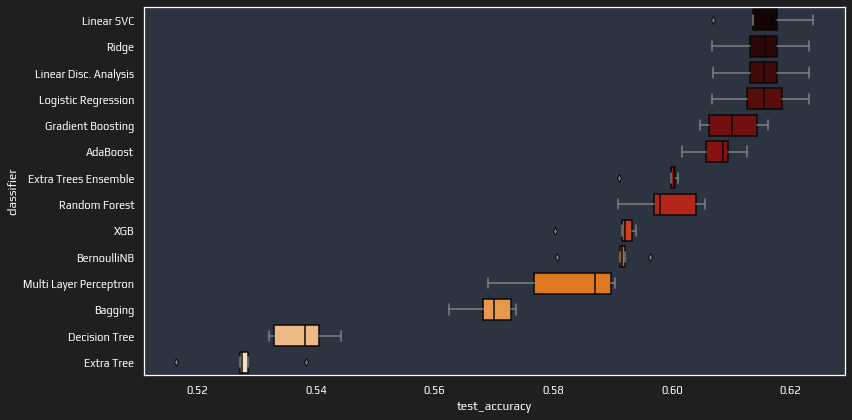

In [20]:
plt.figure(figsize=(12,6))

styling_props = {"whiskerprops":{"color":"gray"}, "capprops":{"color":"gray"}, "flierprops":{"markerfacecolor":"gray"}}

ax = sns.boxplot(x=clfs_df.test_accuracy, y=classifiers_indexes, order=ordered_clfs_df.index, palette="gist_heat", **styling_props)
plt.tight_layout()

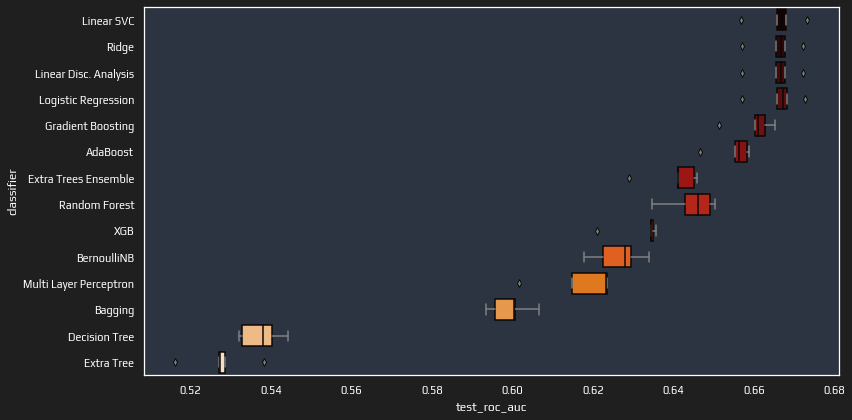

In [19]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=clfs_df.test_roc_auc, y=classifiers_indexes, order=ordered_clfs_df.index, palette="gist_heat", **styling_props)
plt.tight_layout()

In [115]:
ordered_fts_imp_df = fts_imp_df.median().sort_values(ascending=False)

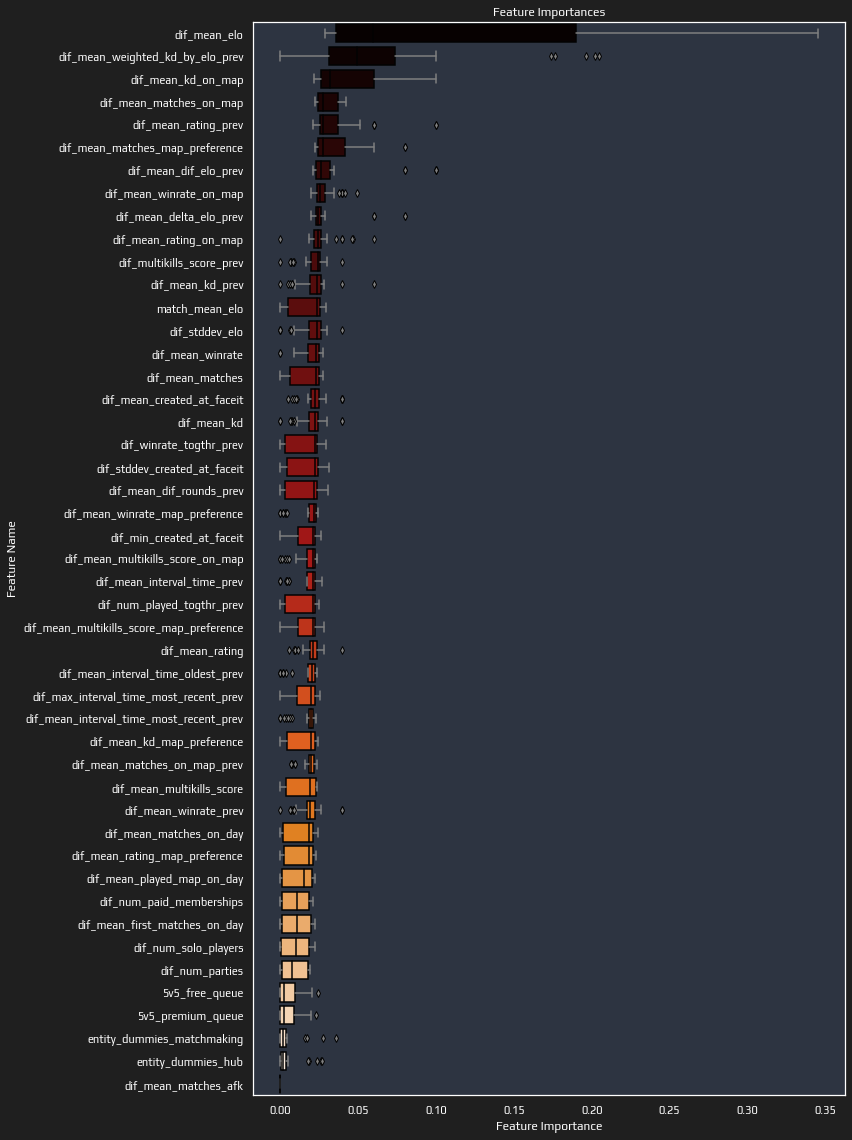

In [237]:
plt.figure(figsize=(12,16))
ax = sns.boxplot(
    data=fts_imp_df.melt(),
    y="variable",
    x="value",
    order=ordered_fts_imp_df.index,
    palette="gist_heat",
    **styling_props)
    
ax.set_ylabel("Feature Name")
ax.set_xlabel("Feature Importance")
plt.tight_layout()

Write about most promising algorithms based on the results and take into account the algorithms that usually yield better results (such as in Kaggle competitions).

Get Feature importance for the several tree-based algorithms.

## Inital Hyperparameter Tuning

Perform simple hyperparameter tuning on a small range of parameters of the best or most promising algorithms before going into feature selection.

There are some highly regarded algorithms such as XGBoost that currently have a subpar performance, probably due to inadequate hyperparameters. So, using the *raw* and *untuned* version of XGBoost during Feature Selection will propagate such errors and lead to an non-optimal solution.

In [ ]:
# Baseline  Test acc    Train acc   Test auc    Train auc
# XGB	    0.592040	0.802918	0.634492	0.892105

In [255]:
xgb_params = {
    "learning_rate": [0.01, 0.05],
    "n_estimators":[50, 100],
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

In [256]:
xgb = XGBClassifier(random_state=SEED)
gs = GridSearchCV(estimator=xgb, param_grid = xgb_params, cv=cv_folds, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1, return_train_score=True, verbose=2)

gs.fit(X_train, y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=15,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, vali

In [257]:
print("Best AUC:", gs.best_score_)
print("Best XGB params:", gs.best_params_)
best_xgb = gs.best_estimator_

Best AUC: 0.6599407272687627
Best XGB params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}


## Feature Selection

Recursive feature elimination with cross-validation to select the number of features.

In [260]:
feature_selector = RFECV(best_xgb, cv=cv_folds, step=1, scoring="roc_auc")
feature_selector.fit(X_train, y_train)

RFECV(cv=5,
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=5, min_child_weight=5,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              random_state=15, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None),
      scoring='roc_auc')

In [261]:
# list of tuples (n_features, auc_test_score) starting at n_features=1 until 47
n_features_vs_auc = enumerate(feature_selector.cv_results_["mean_test_score"], 1)
n_features_vs_auc_df = pd.DataFrame(n_features_vs_auc, columns=["n_features", "AUC"])

In [282]:
n_features_opt, auc_opt = n_features_vs_auc_df.sort_values(by="AUC").iloc[-1]
print(f"Max AUC {auc_opt:.4f} for {n_features_opt:.0f} features")

Max AUC 0.6603 for 24 features


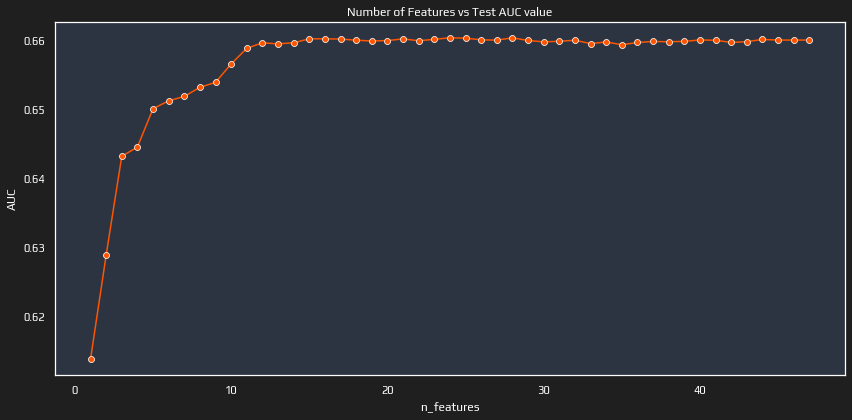

In [283]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=n_features_vs_auc_df, x="n_features", y="AUC", marker="o")
ax.set_title("Number of Features vs Test AUC value")
plt.tight_layout()

In [263]:
n_features_in_ = feature_selector.n_features_in_
n_features = feature_selector.n_features_
# Get selected features
selected_features = feature_selector.feature_names_in_[feature_selector.support_]

nl = '\n'
print(f'From {n_features_in_} features only {n_features} were selected:{nl}{nl.join(selected_features)}')

From 47 features only 24 were selected:
dif_mean_elo
dif_stddev_elo
dif_num_parties
dif_mean_winrate
dif_mean_kd
dif_mean_multikills_score
dif_mean_rating
dif_mean_matches_on_map
dif_mean_winrate_on_map
dif_mean_kd_on_map
dif_mean_multikills_score_on_map
dif_mean_rating_on_map
dif_mean_matches_map_preference
dif_mean_kd_map_preference
dif_mean_created_at_faceit
dif_mean_matches_on_map_prev
dif_mean_winrate_prev
dif_mean_kd_prev
dif_mean_weighted_kd_by_elo_prev
dif_multikills_score_prev
dif_mean_rating_prev
dif_mean_interval_time_most_recent_prev
dif_mean_delta_elo_prev
dif_mean_dif_elo_prev


In [15]:
selected_features = ["dif_mean_elo",
"dif_stddev_elo",
"dif_num_parties",
"dif_mean_winrate",
"dif_mean_kd",
"dif_mean_multikills_score",
"dif_mean_rating",
"dif_mean_matches_on_map",
"dif_mean_winrate_on_map",
"dif_mean_kd_on_map",
"dif_mean_multikills_score_on_map",
"dif_mean_rating_on_map",
"dif_mean_matches_map_preference",
"dif_mean_kd_map_preference",
"dif_mean_created_at_faceit",
"dif_mean_matches_on_map_prev",
"dif_mean_winrate_prev",
"dif_mean_kd_prev",
"dif_mean_weighted_kd_by_elo_prev",
"dif_multikills_score_prev",
"dif_mean_rating_prev",
"dif_mean_interval_time_most_recent_prev",
"dif_mean_delta_elo_prev",
"dif_mean_dif_elo_prev"]

In [16]:
X_train_ft_sel = X_train[selected_features]
X_test_ft_sel = X_test[selected_features]

## Extensive Hyperparameter Tuning

Selected algorithms to perform hyperparameter tuning:

* Linear SVC
* Ridge
* Linear Discriminant Analysis
* Logistic Regression
* Gradient Boosting
* AdaBoost
* Random Forest
* XGB

In [21]:
best_algs = {}

In [22]:
def perform_grid_search_cv(clf, params, X_train=X_train, y_train=y_train, cv=cv_folds, scoring_metrics=scoring_metrics):
    gs = GridSearchCV(
        estimator=clf,
        param_grid=params,
        cv=cv_folds, 
        scoring=scoring_metrics,
        refit='roc_auc',
        n_jobs=-1,
        return_train_score=True,
        verbose=2)
    
    gs.fit(X_train, y_train)
    return gs

### Linear SVC

In [23]:
l_svc_params = {
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "C":  [0.1, 1, 10, 100]
}

In [24]:
gs_linear_svc = perform_grid_search_cv(LinearSVC(random_state=SEED), l_svc_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [25]:
best_algs["Linear SVC"] = gs_linear_svc.best_estimator

### Ridge

In [26]:
ridge_params = {
    "alpha": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

In [27]:
gs_ridge = perform_grid_search_cv(RidgeClassifier(random_state=SEED), ridge_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [28]:
best_algs["Ridge"] = gs_ridge.best_estimator_

### Linear Discriminant Analysis

In [35]:
lda_params = {
    'solver' : ['svd', 'lsqr', 'eigen'],
    'shrinkage': np.arange(0, 1, 0.01)
}

In [36]:
gs_lda = perform_grid_search_cv(LinearDiscriminantAnalysis(), lda_params)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [ ]:
best_algs["Linear Disc. Analysis"] = gs_lda.best_estimator_

### Logistic Regression

In [40]:
lr_params = {
    "penalty": ['l1', 'l2', 'elasticnet', None],
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "C": [100, 10, 1.0, 0.1, 0.01]
}

In [41]:
gs_lr = perform_grid_search_cv(LogisticRegression(random_state=SEED), lr_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [44]:
best_algs["Logistic Regression"] = gs_lr.best_estimator_

### Gradient Boosting

In [51]:
# gb_params = {
#     "n_estimators": [10, 100, 1000],
#     "learning_rate": [0.001, 0.01, 0.1],
#     "subsample": [0.5, 0.7, 1.0],
#     "max_depth": [3, 7, 9]
# }

gb_params = {
    "n_estimators": [10, 100],
    "learning_rate": [0.01, 0.1]
}

In [52]:
gs_gb = perform_grid_search_cv(GradientBoostingClassifier(random_state=SEED), gb_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [55]:
best_algs["Gradient Boosting"] = gs_gb.best_estimator_

### AdaBoost

In [56]:
ada_params = {
    "n_estimators": [10, 50, 100, 500],
    "learning_rate": [0.01],
    # "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
}

In [57]:
gs_ada = perform_grid_search_cv(AdaBoostClassifier(random_state=SEED), ada_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [63]:
best_algs["AdaBoost"] = gs_ada.best_estimator_

### Random Forest

In [58]:
rf_params = {
    "criterion": ['gini', 'entropy'],
    "n_estimators": [50, 100],
    "max_depth": [None, 5, 10],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [5, 10]
}

In [59]:
gs_rf = perform_grid_search_cv(RandomForestClassifier(random_state=SEED), rf_params)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [64]:
best_algs["Random Forest"] = gs_rf.best_estimator_

### XGBoost

In [60]:
xgb_params = {
    "learning_rate": [0.01, 0.05],
    "n_estimators":[50, 100],
    'max_depth':range(5,10,2),
}

In [61]:
gs_xgb = perform_grid_search_cv(XGBClassifier(random_state=SEED), xgb_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [65]:
best_algs["XGB"] = gs_xgb.best_estimator_

In [86]:
clfs_df, fts_imp_df = [], []

for name, clf in best_algs_correct.items():
    print("Fitting", name)

    index = pd.MultiIndex.from_product([[name], range(cv_folds)], names=["classifier", "fold_number"])
    output = cross_validate(clf, X_train, y_train, cv=cv_folds, scoring=scoring_metrics, return_train_score=True, return_estimator=True)

    clfs_df.append(pd.DataFrame(output, index=index))

    if name in has_feature_importances:
        fts_imp_df.append(pd.DataFrame([e.feature_importances_ for e in output["estimator"]], index=index, columns=X_train.columns))


clfs_df = pd.concat(clfs_df)
fts_imp_df = pd.concat(fts_imp_df)

Fitting Linear SVC
Fitting Ridge
Fitting Logistic Regression
Fitting Gradient Boosting
Fitting AdaBoost
Fitting Random Forest
Fitting XGB


In [88]:
ordered_clfs_df = clfs_df.groupby(by="classifier").median().sort_values(by="test_accuracy", ascending=False)
ordered_clfs_df

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
classifier,,,,,,
Linear SVC,13.717352,0.011968,0.616915,0.616848,0.666948,0.667455
Logistic Regression,3.156453,0.013956,0.616604,0.617858,0.667180,0.667566
Ridge,0.090072,0.011939,0.615568,0.616718,0.666696,0.667275
Gradient Boosting,51.257265,0.048860,0.610075,0.633586,0.661058,0.690388
XGB,6.121149,0.091992,0.609867,0.651388,0.662361,0.716215
Random Forest,15.254572,0.338096,0.607276,0.715407,0.657209,0.798116
AdaBoost,108.978101,3.242402,0.606240,0.607623,0.653309,0.654944


In [89]:
# 'Ignore' fold number index
classifiers_indexes = clfs_df.index.get_level_values(level=0)

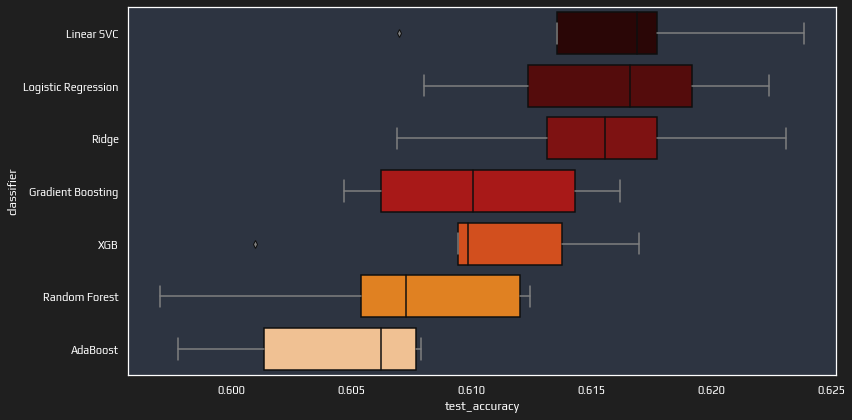

In [90]:
plt.figure(figsize=(12,6))

styling_props = {"whiskerprops":{"color":"gray"}, "capprops":{"color":"gray"}, "flierprops":{"markerfacecolor":"gray"}}

ax = sns.boxplot(x=clfs_df.test_accuracy, y=classifiers_indexes, order=ordered_clfs_df.index, palette="gist_heat", **styling_props)
plt.tight_layout()

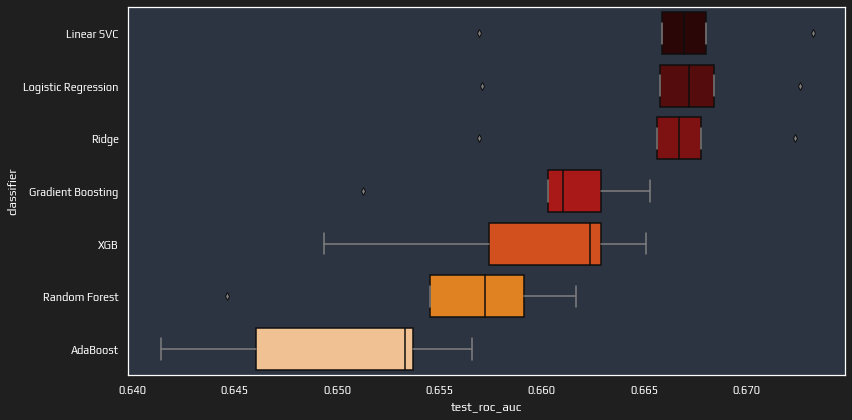

In [91]:
plt.figure(figsize=(12,6))

styling_props = {"whiskerprops":{"color":"gray"}, "capprops":{"color":"gray"}, "flierprops":{"markerfacecolor":"gray"}}

ax = sns.boxplot(x=clfs_df.test_roc_auc, y=classifiers_indexes, order=ordered_clfs_df.index, palette="gist_heat", **styling_props)
plt.tight_layout()

# Neural Networks

In [92]:
# Initializing Neural Network
nn = Sequential()

In [93]:
# Adding the input layer
nn.add(Dense(units=64, activation="relu", input_dim=len(X_train.columns)))

# Adding the hidden layers
nn.add(Dropout(0.5))
nn.add(Dense(units=128, activation="relu"))
nn.add(Dropout(0.5))
nn.add(Dense(units=128, activation="relu"))
nn.add(Dropout(0.5))
nn.add(Dense(units=64, activation="relu"))

# Adding the output layer
nn.add(Dense(units=1, activation="sigmoid"))

In [94]:
nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [95]:
nn.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1)

Epoch 1/20
754/754 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5668
Epoch 2/20
754/754 [==============================] - 2s 2ms/step - loss: 0.6626 - accuracy: 0.5961
Epoch 3/20
754/754 [==============================] - 2s 2ms/step - loss: 0.6583 - accuracy: 0.6041
Epoch 4/20
754/754 [==============================] - 2s 2ms/step - loss: 0.6553 - accuracy: 0.6078
Epoch 5/20
754/754 [==============================] - 2s 3ms/step - loss: 0.6534 - accuracy: 0.6115
Epoch 6/20
754/754 [==============================] - 2s 3ms/step - loss: 0.6526 - accuracy: 0.6121
Epoch 7/20
754/754 [==============================] - 2s 3ms/step - loss: 0.6516 - accuracy: 0.6149
Epoch 8/20
754/754 [==============================] - 2s 2ms/step - loss: 0.6506 - accuracy: 0.6173
Epoch 9/20
754/754 [==============================] - 2s 3ms/step - loss: 0.6509 - accuracy: 0.6149
Epoch 10/20
754/754 [==============================] - 2s 2ms/step - loss: 0.6495 - accuracy: 0.6178

In [99]:
y_pred = nn.predict(X_test)
y_pred = y_pred > 0.5
print(classification_report(y_test, y_pred))
auc_score = roc_auc_score(y_test, nn.predict(X_test).ravel())
print("AUC Score", auc_score)

              precision    recall  f1-score   support

           0       0.62      0.60      0.61     10398
           1       0.61      0.63      0.62     10278

    accuracy                           0.61     20676
   macro avg       0.61      0.61      0.61     20676
weighted avg       0.61      0.61      0.61     20676

AUC Score 0.6643374395685311


# Stacking Classifier

In [114]:
estimators = list(zip(best_algs.keys(), best_algs.values()))

In [116]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=cv_folds)

In [117]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('Linear SVC', LinearSVC(C=1, random_state=15)),
                               ('Ridge',
                                RidgeClassifier(alpha=0.1, random_state=15)),
                               ('Logistic Regression',
                                LogisticRegression(C=0.1, random_state=15,
                                                   solver='sag')),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(random_state=15)),
                               ('AdaBoost',
                                AdaBoostClassifier(learning_rate=0.01,
                                                   n_estimators=500,
                                                   random...
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              le

,0,1,macro avg,weighted avg
precision,0.621281,0.618963,0.620122,0.620129
recall,0.626659,0.613543,0.620101,0.620139
f1-score,0.623959,0.616242,0.620100,0.620122
support,10398.000000,10278.000000,20676.000000,20676.000000


Train Accuracy: 0.6271		Test Accuracy: 0.6201


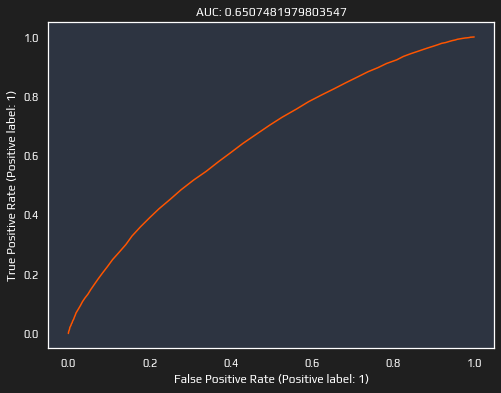

In [118]:
print_metrics(stacking_clf, X_train, y_train, X_test, y_test)

# Store Model

In [123]:
current_date_string = datetime.utcnow().strftime("%Y_%m_%d_%H_%M_%S")
model_folder_path = MODEL_DIR / f'model_{current_date_string}'

# create models folder
os.mkdir(model_folder_path)

In [125]:
# save models
joblib.dump(stacking_clf, f'{str(model_folder_path)}/model.joblib')

['d:\\Portfolio\\faceit-predictor\\ML\\models\\model_2021_10_25_03_46_33/model.joblib']